# Coronal Heating Detection Using GOES X-ray Data

This notebook analyzes GOES X-ray data to detect coronal heating events and nanoflares using signal processing techniques and machine learning.

## Objectives:
1. Load and visualize 2025 XRSA/XRSB data
2. Apply baseline correction and filtering
3. Detect nanoflares using statistical methods
4. Build machine learning models for automated detection

Data source: 2025_xrsa_xrsb.csv containing GOES X-ray flux measurements

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter, find_peaks
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Initial Exploration

In [3]:
# Load the data
data_path = r'data\2025_xrsa_xrsb.csv'
df = pd.read_csv(data_path)

# Display basic information about the dataset
print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Convert time to datetime for better handling
df['datetime'] = pd.to_datetime(df['time_seconds'], unit='s')
print(f"\nTime range: {df['datetime'].min()} to {df['datetime'].max()}")

Dataset Information:
Shape: (138241, 4)
Columns: ['time_minutes', 'time_seconds', 'xrsa_flux_observed', 'xrsb_flux_observed']

First few rows:
   time_minutes  time_seconds  xrsa_flux_observed  xrsb_flux_observed
0             0             0        0.000000e+00            0.000000
1             1            60        2.620000e-07            0.000006
2             2           120        2.610000e-07            0.000006
3             3           180        2.510000e-07            0.000006
4             4           240        2.490000e-07            0.000006

Dataset statistics:
        time_minutes  time_seconds  xrsa_flux_observed  xrsb_flux_observed
count  138241.000000  1.382410e+05        1.290370e+05       129037.000000
mean    69120.000000  4.147200e+06        1.348217e-07            0.000002
std     39906.883619  2.394413e+06        8.298074e-07            0.000004
min         0.000000  0.000000e+00        0.000000e+00            0.000000
25%     34560.000000  2.073600e+06       

## 2. Initial Data Visualization (1000 samples)

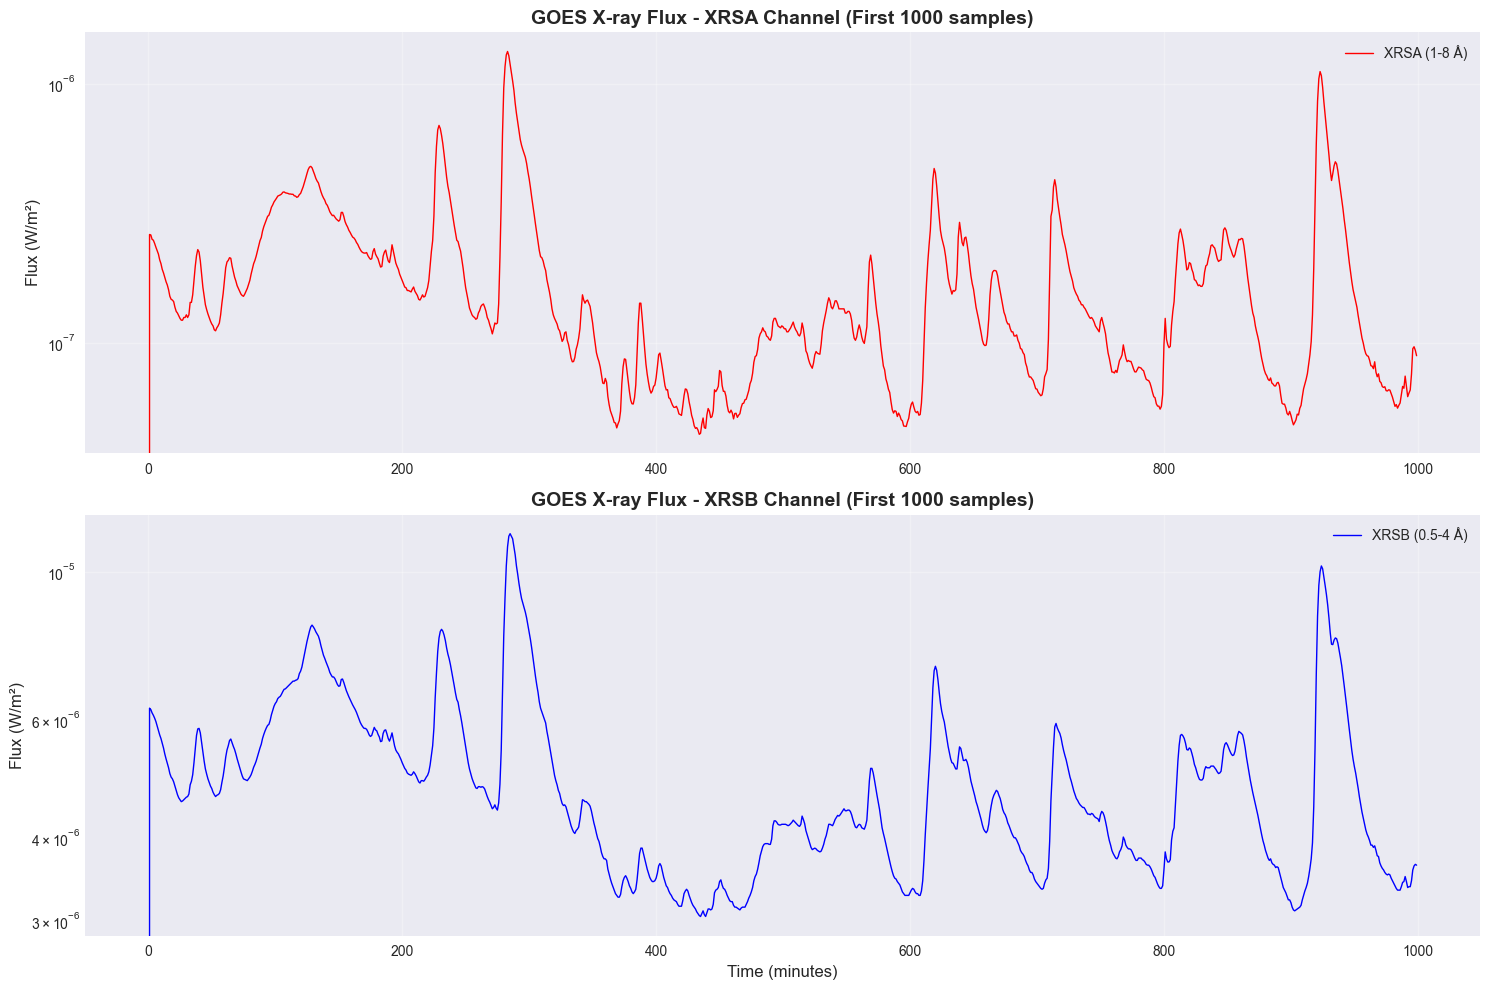

Sample Statistics (First 1000 points):
XRSA Range: 0.00e+00 to 1.34e-06
XRSB Range: 0.00e+00 to 1.14e-05


In [4]:
# Plot first 1000 samples
sample_size = 1000
df_sample = df.head(sample_size).copy()

# Create subplots for XRSA and XRSB
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot XRSA flux
ax1.plot(df_sample['time_minutes'], df_sample['xrsa_flux_observed'], 
         color='red', linewidth=1, label='XRSA (1-8 Å)')
ax1.set_title('GOES X-ray Flux - XRSA Channel (First 1000 samples)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Flux (W/m²)', fontsize=12)
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot XRSB flux
ax2.plot(df_sample['time_minutes'], df_sample['xrsb_flux_observed'], 
         color='blue', linewidth=1, label='XRSB (0.5-4 Å)')
ax2.set_title('GOES X-ray Flux - XRSB Channel (First 1000 samples)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time (minutes)', fontsize=12)
ax2.set_ylabel('Flux (W/m²)', fontsize=12)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Display sample statistics
print("Sample Statistics (First 1000 points):")
print(f"XRSA Range: {df_sample['xrsa_flux_observed'].min():.2e} to {df_sample['xrsa_flux_observed'].max():.2e}")
print(f"XRSB Range: {df_sample['xrsb_flux_observed'].min():.2e} to {df_sample['xrsb_flux_observed'].max():.2e}")

## 3. Baseline Correction

Baseline correction is crucial for detecting small-scale heating events. We'll use a rolling minimum approach to estimate and subtract the baseline.

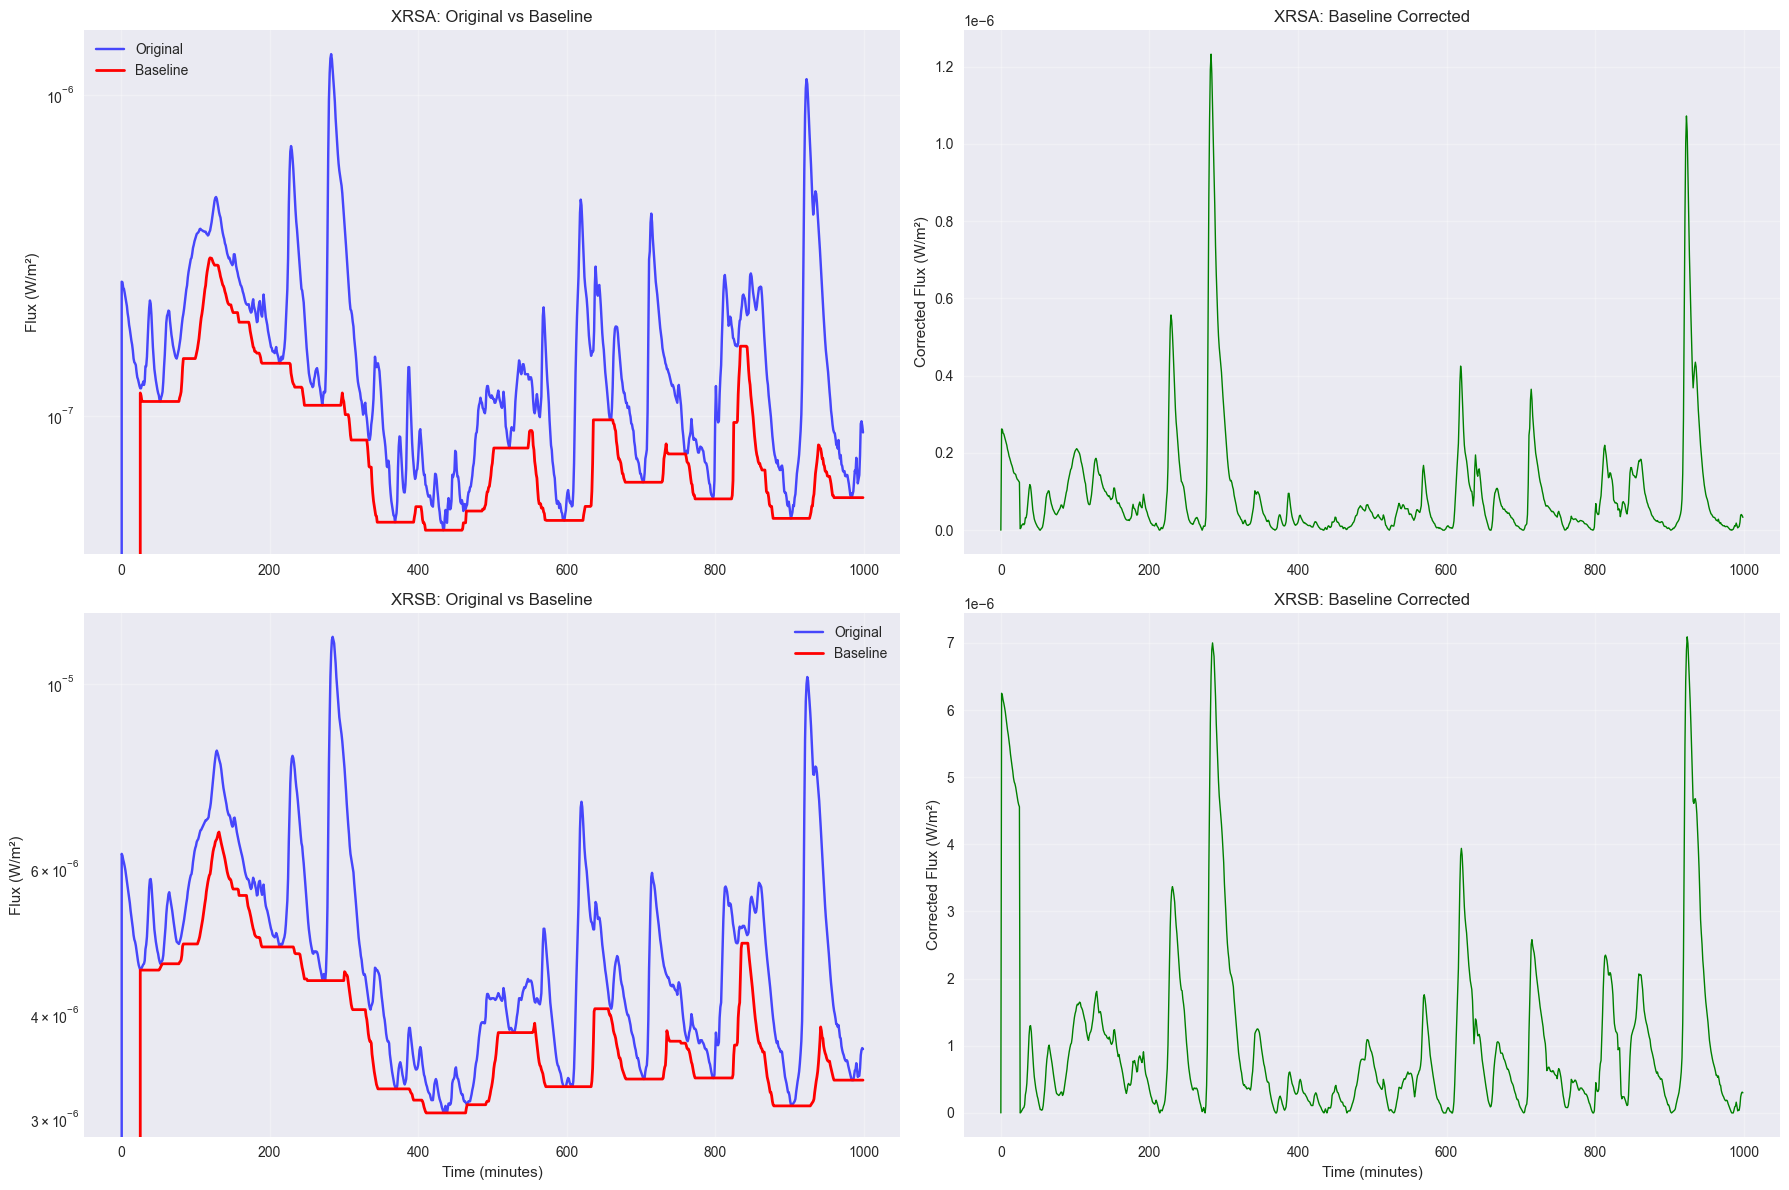

Baseline correction completed!


In [5]:
def baseline_correction(data, window_size=100):
    """
    Apply baseline correction using rolling minimum approach
    """
    # Calculate rolling minimum as baseline estimate
    baseline = pd.Series(data).rolling(window=window_size, center=True, min_periods=1).min()
    
    # Subtract baseline
    corrected_data = data - baseline
    
    return corrected_data, baseline

# Apply baseline correction to sample data
window_size = 50  # Adjust based on expected nanoflare duration

# Baseline correction for XRSA
df_sample['xrsa_corrected'], df_sample['xrsa_baseline'] = baseline_correction(
    df_sample['xrsa_flux_observed'], window_size)

# Baseline correction for XRSB  
df_sample['xrsb_corrected'], df_sample['xrsb_baseline'] = baseline_correction(
    df_sample['xrsb_flux_observed'], window_size)

# Visualize baseline correction
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# XRSA original vs baseline
axes[0,0].plot(df_sample['time_minutes'], df_sample['xrsa_flux_observed'], 'b-', label='Original', alpha=0.7)
axes[0,0].plot(df_sample['time_minutes'], df_sample['xrsa_baseline'], 'r-', label='Baseline', linewidth=2)
axes[0,0].set_title('XRSA: Original vs Baseline')
axes[0,0].set_ylabel('Flux (W/m²)')
axes[0,0].set_yscale('log')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# XRSA corrected
axes[0,1].plot(df_sample['time_minutes'], df_sample['xrsa_corrected'], 'g-', linewidth=1)
axes[0,1].set_title('XRSA: Baseline Corrected')
axes[0,1].set_ylabel('Corrected Flux (W/m²)')
axes[0,1].grid(True, alpha=0.3)

# XRSB original vs baseline
axes[1,0].plot(df_sample['time_minutes'], df_sample['xrsb_flux_observed'], 'b-', label='Original', alpha=0.7)
axes[1,0].plot(df_sample['time_minutes'], df_sample['xrsb_baseline'], 'r-', label='Baseline', linewidth=2)
axes[1,0].set_title('XRSB: Original vs Baseline')
axes[1,0].set_xlabel('Time (minutes)')
axes[1,0].set_ylabel('Flux (W/m²)')
axes[1,0].set_yscale('log')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# XRSB corrected
axes[1,1].plot(df_sample['time_minutes'], df_sample['xrsb_corrected'], 'g-', linewidth=1)
axes[1,1].set_title('XRSB: Baseline Corrected')
axes[1,1].set_xlabel('Time (minutes)')
axes[1,1].set_ylabel('Corrected Flux (W/m²)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Baseline correction completed!")

## 4. Savitzky-Golay Filtering

Apply Savitzky-Golay filter to smooth the data while preserving important features like nanoflare signatures.

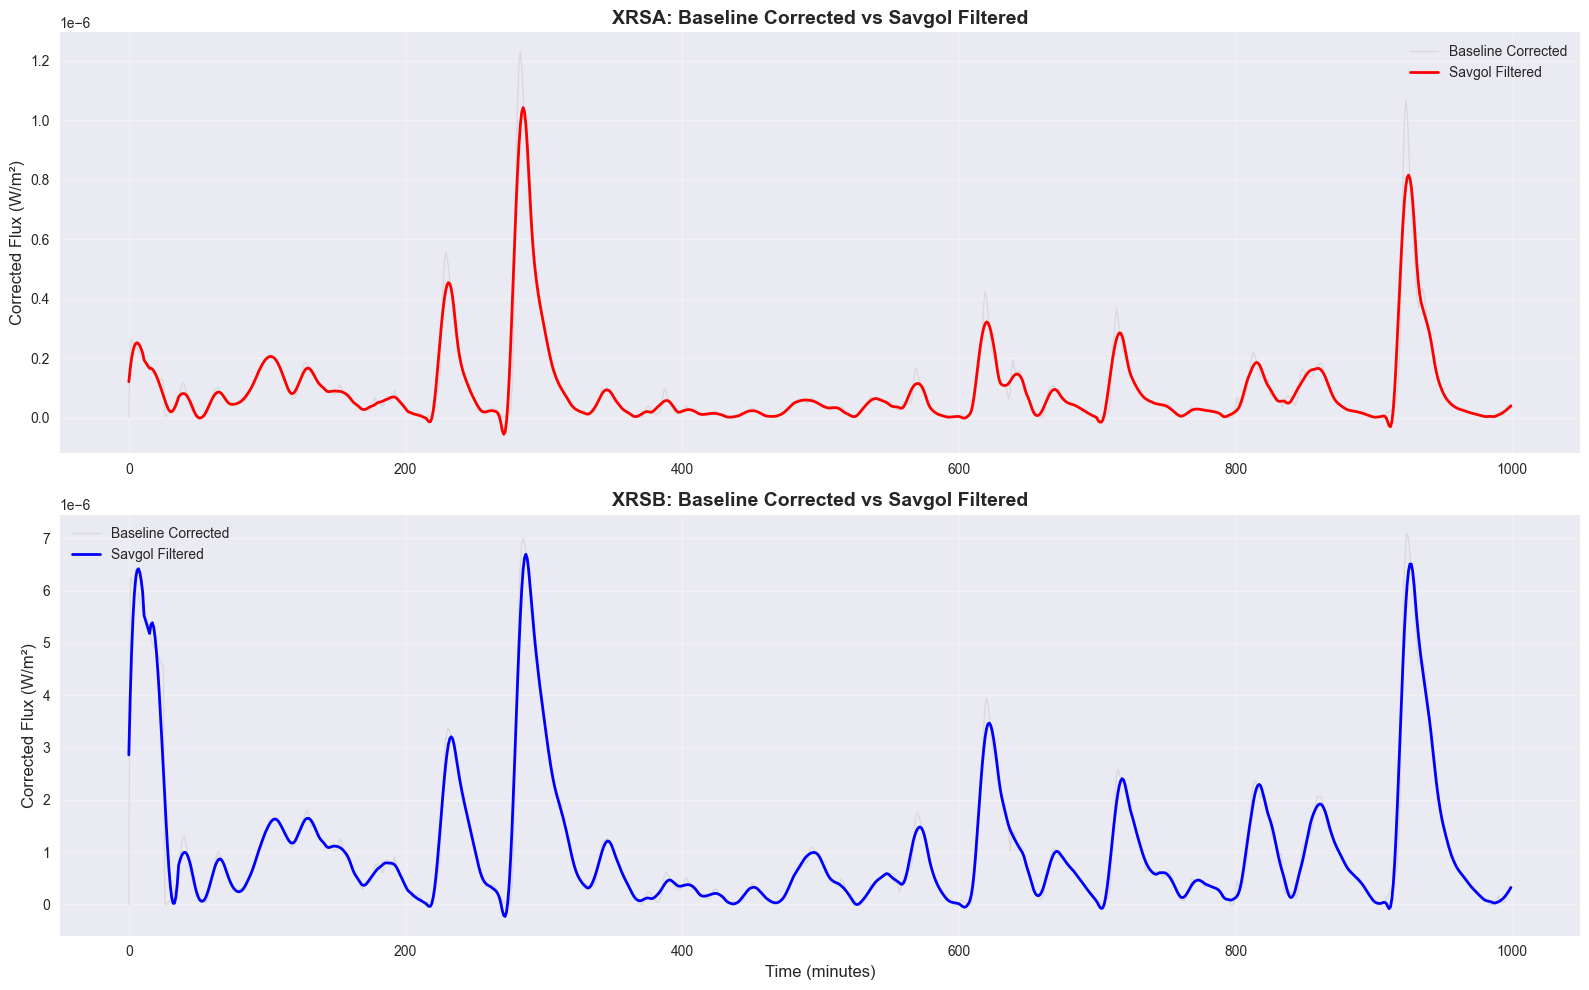

Savitzky-Golay filtering completed!
Filter parameters: window_length=21, polyorder=3


In [6]:
# Apply Savitzky-Golay filter
def apply_savgol_filter(data, window_length=21, polyorder=3):
    """
    Apply Savitzky-Golay filter to smooth data while preserving features
    """
    # Ensure window_length is odd and greater than polyorder
    if window_length % 2 == 0:
        window_length += 1
    
    if window_length <= polyorder:
        window_length = polyorder + 2 if (polyorder + 2) % 2 == 1 else polyorder + 3
    
    return savgol_filter(data, window_length, polyorder)

# Apply filtering to baseline-corrected data
window_length = 21  # Window size for smoothing
polyorder = 3       # Polynomial order

df_sample['xrsa_filtered'] = apply_savgol_filter(df_sample['xrsa_corrected'], window_length, polyorder)
df_sample['xrsb_filtered'] = apply_savgol_filter(df_sample['xrsb_corrected'], window_length, polyorder)

# Visualize filtering results
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# XRSA filtering comparison
axes[0].plot(df_sample['time_minutes'], df_sample['xrsa_corrected'], 
             'lightgray', label='Baseline Corrected', alpha=0.7, linewidth=1)
axes[0].plot(df_sample['time_minutes'], df_sample['xrsa_filtered'], 
             'red', label='Savgol Filtered', linewidth=2)
axes[0].set_title('XRSA: Baseline Corrected vs Savgol Filtered', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Corrected Flux (W/m²)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# XRSB filtering comparison
axes[1].plot(df_sample['time_minutes'], df_sample['xrsb_corrected'], 
             'lightgray', label='Baseline Corrected', alpha=0.7, linewidth=1)
axes[1].plot(df_sample['time_minutes'], df_sample['xrsb_filtered'], 
             'blue', label='Savgol Filtered', linewidth=2)
axes[1].set_title('XRSB: Baseline Corrected vs Savgol Filtered', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (minutes)', fontsize=12)
axes[1].set_ylabel('Corrected Flux (W/m²)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Savitzky-Golay filtering completed!")
print(f"Filter parameters: window_length={window_length}, polyorder={polyorder}")

## 5. Statistical Nanoflare Detection

Use statistical methods to identify potential nanoflare events based on signal characteristics.

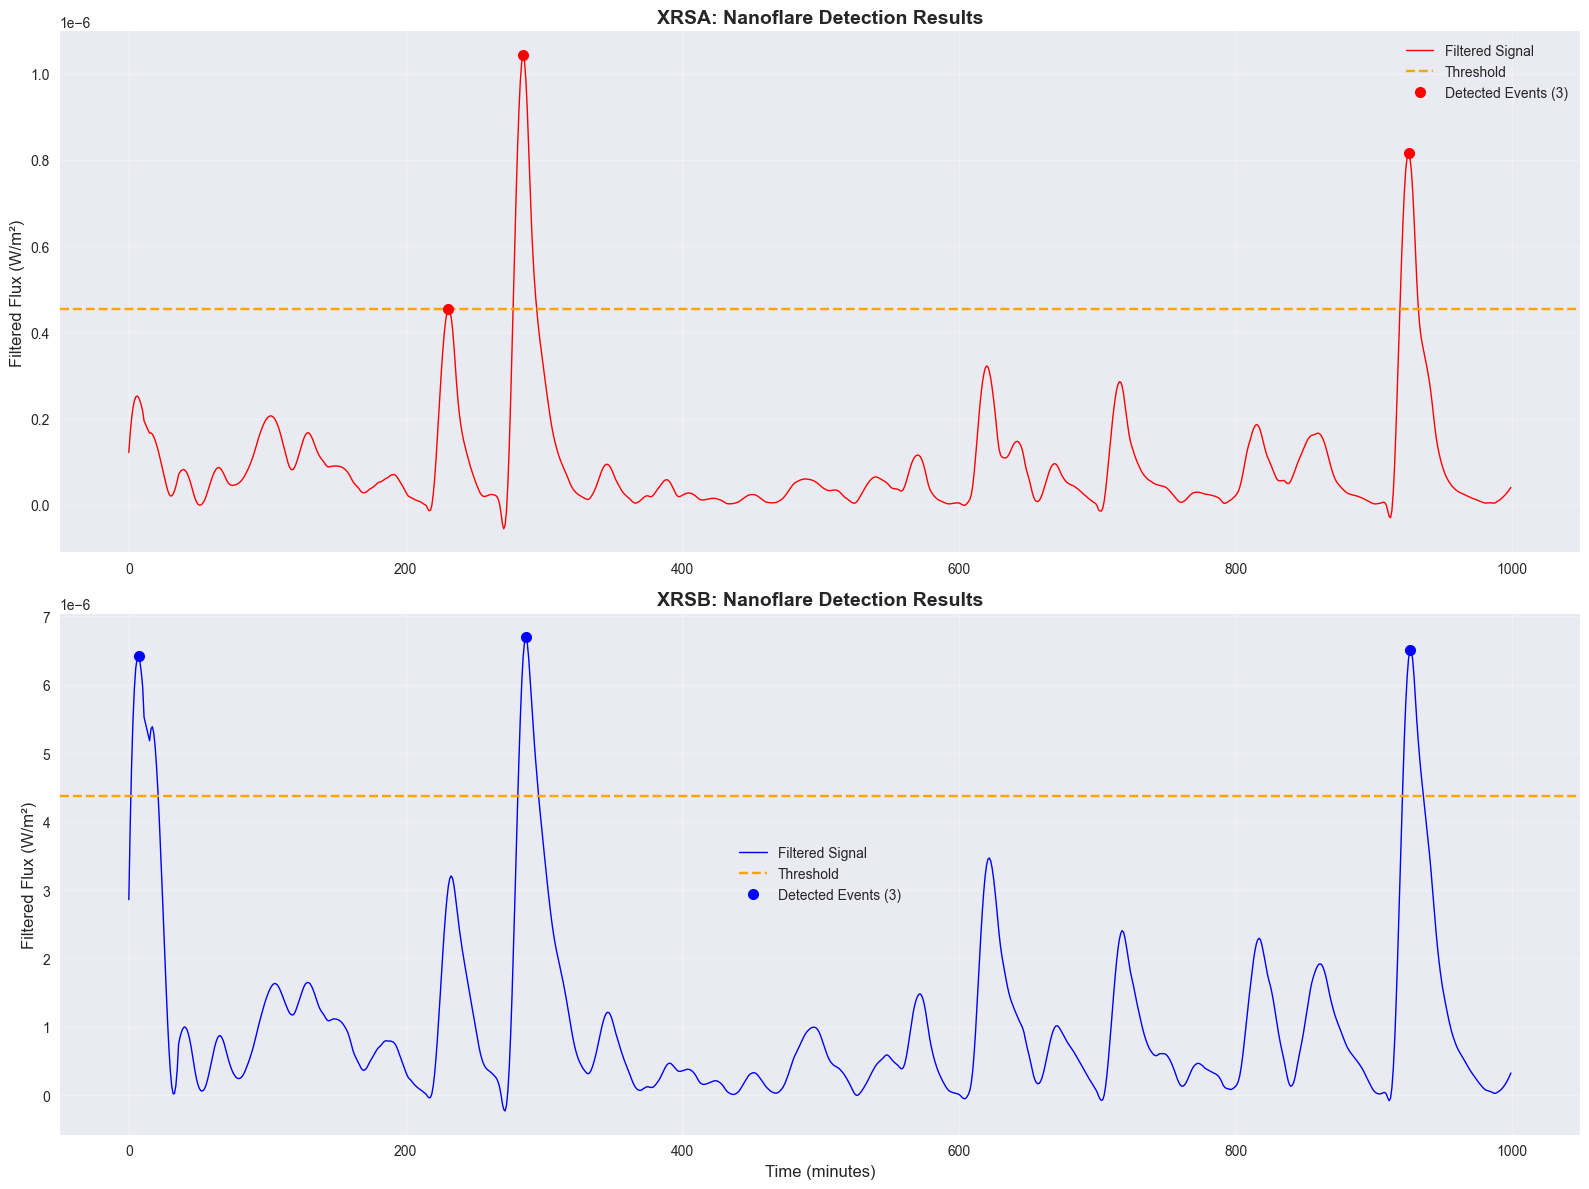

Nanoflare Detection Summary:
XRSA Channel: 3 events detected
XRSB Channel: 3 events detected
XRSA Event times (minutes): [231 285 925]
XRSA Event intensities: [4.54464858e-07 1.04330075e-06 8.16264923e-07]
XRSB Event times (minutes): [  7 287 926]
XRSB Event intensities: [6.41835121e-06 6.69610984e-06 6.50930042e-06]


In [7]:
def detect_nanoflares_statistical(data, threshold_std=3, min_duration=3, prominence=None):
    """
    Detect nanoflares using statistical methods
    
    Parameters:
    - data: filtered flux data
    - threshold_std: standard deviation threshold for detection
    - min_duration: minimum duration of events in data points
    - prominence: minimum prominence for peak detection
    """
    # Calculate statistics
    mean_val = np.mean(data)
    std_val = np.std(data)
    
    # Set threshold based on standard deviation
    threshold = mean_val + threshold_std * std_val
    
    # Find peaks above threshold
    if prominence is None:
        prominence = std_val * 0.5
    
    peaks, properties = find_peaks(data, 
                                 height=threshold,
                                 distance=min_duration,
                                 prominence=prominence)
    
    return peaks, threshold, properties

# Apply nanoflare detection to both channels
# XRSA detection
xrsa_peaks, xrsa_threshold, xrsa_props = detect_nanoflares_statistical(
    df_sample['xrsa_filtered'], threshold_std=2.5, min_duration=5)

# XRSB detection  
xrsb_peaks, xrsb_threshold, xrsb_props = detect_nanoflares_statistical(
    df_sample['xrsb_filtered'], threshold_std=2.5, min_duration=5)

# Visualize detection results
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# XRSA detection
axes[0].plot(df_sample['time_minutes'], df_sample['xrsa_filtered'], 'red', linewidth=1, label='Filtered Signal')
axes[0].axhline(y=xrsa_threshold, color='orange', linestyle='--', label=f'Threshold')
axes[0].plot(df_sample['time_minutes'].iloc[xrsa_peaks], 
             df_sample['xrsa_filtered'].iloc[xrsa_peaks], 
             'ro', markersize=8, label=f'Detected Events ({len(xrsa_peaks)})')
axes[0].set_title('XRSA: Nanoflare Detection Results', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Filtered Flux (W/m²)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# XRSB detection
axes[1].plot(df_sample['time_minutes'], df_sample['xrsb_filtered'], 'blue', linewidth=1, label='Filtered Signal')
axes[1].axhline(y=xrsb_threshold, color='orange', linestyle='--', label=f'Threshold')
axes[1].plot(df_sample['time_minutes'].iloc[xrsb_peaks], 
             df_sample['xrsb_filtered'].iloc[xrsb_peaks], 
             'bo', markersize=8, label=f'Detected Events ({len(xrsb_peaks)})')
axes[1].set_title('XRSB: Nanoflare Detection Results', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (minutes)', fontsize=12)
axes[1].set_ylabel('Filtered Flux (W/m²)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detection summary
print("Nanoflare Detection Summary:")
print(f"XRSA Channel: {len(xrsa_peaks)} events detected")
print(f"XRSB Channel: {len(xrsb_peaks)} events detected")

if len(xrsa_peaks) > 0:
    print(f"XRSA Event times (minutes): {df_sample['time_minutes'].iloc[xrsa_peaks].values}")
    print(f"XRSA Event intensities: {df_sample['xrsa_filtered'].iloc[xrsa_peaks].values}")

if len(xrsb_peaks) > 0:
    print(f"XRSB Event times (minutes): {df_sample['time_minutes'].iloc[xrsb_peaks].values}")
    print(f"XRSB Event intensities: {df_sample['xrsb_filtered'].iloc[xrsb_peaks].values}")

## 6. Machine Learning Model Development

Build and train machine learning models for automated nanoflare detection using feature engineering and classification algorithms.

In [8]:
def create_features(df, window_size=10):
    """
    Create features for machine learning from time series data
    """
    features = pd.DataFrame()
    
    # Original flux values
    features['xrsa_flux'] = df['xrsa_flux_observed']
    features['xrsb_flux'] = df['xrsb_flux_observed']
    
    # Filtered values
    features['xrsa_filtered'] = df['xrsa_filtered']
    features['xrsb_filtered'] = df['xrsb_filtered']
    
    # Statistical features in rolling windows
    for col in ['xrsa_filtered', 'xrsb_filtered']:
        # Rolling statistics
        features[f'{col}_mean'] = df[col].rolling(window=window_size, center=True).mean()
        features[f'{col}_std'] = df[col].rolling(window=window_size, center=True).std()
        features[f'{col}_max'] = df[col].rolling(window=window_size, center=True).max()
        features[f'{col}_min'] = df[col].rolling(window=window_size, center=True).min()
        
        # Derivatives (rate of change)
        features[f'{col}_diff'] = df[col].diff()
        features[f'{col}_diff2'] = df[col].diff().diff()
        
        # Normalized features
        mean_val = df[col].mean()
        std_val = df[col].std()
        features[f'{col}_normalized'] = (df[col] - mean_val) / std_val
    
    # Ratio features
    features['xrsa_xrsb_ratio'] = df['xrsa_filtered'] / (df['xrsb_filtered'] + 1e-10)
    
    # Time-based features
    features['time_minutes'] = df['time_minutes']
    features['time_sin'] = np.sin(2 * np.pi * df['time_minutes'] / (24 * 60))  # Daily cycle
    features['time_cos'] = np.cos(2 * np.pi * df['time_minutes'] / (24 * 60))
    
    return features

# Create features for the sample data
features_df = create_features(df_sample)

# Remove rows with NaN values (due to rolling window calculations)
features_df = features_df.dropna()

print("Feature Engineering Completed!")
print(f"Feature matrix shape: {features_df.shape}")
print(f"Features created: {list(features_df.columns)}")

Feature Engineering Completed!
Feature matrix shape: (991, 22)
Features created: ['xrsa_flux', 'xrsb_flux', 'xrsa_filtered', 'xrsb_filtered', 'xrsa_filtered_mean', 'xrsa_filtered_std', 'xrsa_filtered_max', 'xrsa_filtered_min', 'xrsa_filtered_diff', 'xrsa_filtered_diff2', 'xrsa_filtered_normalized', 'xrsb_filtered_mean', 'xrsb_filtered_std', 'xrsb_filtered_max', 'xrsb_filtered_min', 'xrsb_filtered_diff', 'xrsb_filtered_diff2', 'xrsb_filtered_normalized', 'xrsa_xrsb_ratio', 'time_minutes', 'time_sin', 'time_cos']


In [9]:
def create_labels(features_df, xrsa_peaks, xrsb_peaks, peak_window=5):
    """
    Create labels for supervised learning based on detected peaks
    """
    labels = np.zeros(len(features_df))
    
    # Mark regions around detected peaks as positive examples
    for peak in xrsa_peaks:
        start_idx = max(0, peak - peak_window)
        end_idx = min(len(labels), peak + peak_window + 1)
        if end_idx <= len(labels):
            labels[start_idx:end_idx] = 1
    
    for peak in xrsb_peaks:
        start_idx = max(0, peak - peak_window)
        end_idx = min(len(labels), peak + peak_window + 1)
        if end_idx <= len(labels):
            labels[start_idx:end_idx] = 1
    
    return labels

# Create labels based on statistical detection
# Adjust indices to match the features dataframe (which may be shorter due to dropna)
adjusted_xrsa_peaks = [p for p in xrsa_peaks if p < len(features_df)]
adjusted_xrsb_peaks = [p for p in xrsb_peaks if p < len(features_df)]

labels = create_labels(features_df, adjusted_xrsa_peaks, adjusted_xrsb_peaks)

print("Label Creation Completed!")
print(f"Total samples: {len(labels)}")
print(f"Positive samples (nanoflares): {np.sum(labels)}")
print(f"Negative samples: {len(labels) - np.sum(labels)}")
print(f"Class distribution: {np.sum(labels)/len(labels)*100:.2f}% positive")

Label Creation Completed!
Total samples: 991
Positive samples (nanoflares): 47.0
Negative samples: 944.0
Class distribution: 4.74% positive


In [10]:
# Prepare data for machine learning
# Select relevant features (exclude time-based for now)
feature_columns = [col for col in features_df.columns if col not in ['time_minutes']]
X = features_df[feature_columns].values
y = labels

# Handle any remaining NaN values
nan_mask = np.isnan(X).any(axis=1) | np.isnan(y)
X = X[~nan_mask]
y = y[~nan_mask]

print(f"Clean dataset shape: {X.shape}")
print(f"Features used: {len(feature_columns)}")

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training positive ratio: {np.sum(y_train)/len(y_train)*100:.2f}%")
print(f"Test positive ratio: {np.sum(y_test)/len(y_test)*100:.2f}%")

Clean dataset shape: (991, 21)
Features used: 21
Training set: 693 samples
Test set: 298 samples
Training positive ratio: 4.76%
Test positive ratio: 4.70%


### 6.1 Model Training

In [11]:
# Train multiple machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train models and store results
model_results = {}
trained_models = {}

print("Training Models...")
print("=" * 50)

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_auc': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"  CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  Test AUC: {auc_score:.4f}")
    print()

print("Model training completed!")

Training Models...
Training Random Forest...
  CV AUC: 0.9977 ± 0.0045
  Test AUC: 0.9995

Training SVM...
  CV AUC: 0.9977 ± 0.0045
  Test AUC: 0.9995

Training SVM...
  CV AUC: 0.9931 ± 0.0082
  Test AUC: 0.9980

Training Logistic Regression...
  CV AUC: 0.9969 ± 0.0023
  Test AUC: 0.9982

Training Gradient Boosting...
  CV AUC: 0.9931 ± 0.0082
  Test AUC: 0.9980

Training Logistic Regression...
  CV AUC: 0.9969 ± 0.0023
  Test AUC: 0.9982

Training Gradient Boosting...
  CV AUC: 0.9837 ± 0.0303
  Test AUC: 1.0000

Model training completed!
  CV AUC: 0.9837 ± 0.0303
  Test AUC: 1.0000

Model training completed!


### 6.2 Model Evaluation and Comparison

Model Performance Comparison:
                     Accuracy  Precision  Recall  F1-Score     AUC  CV_Mean
Random Forest          0.9933     0.9286  0.9286    0.9286  0.9995   0.9977
SVM                    0.9866     0.7778  1.0000    0.8750  0.9980   0.9931
Logistic Regression    0.9933     0.8750  1.0000    0.9333  0.9982   0.9969
Gradient Boosting      0.9966     0.9333  1.0000    0.9655  1.0000   0.9837


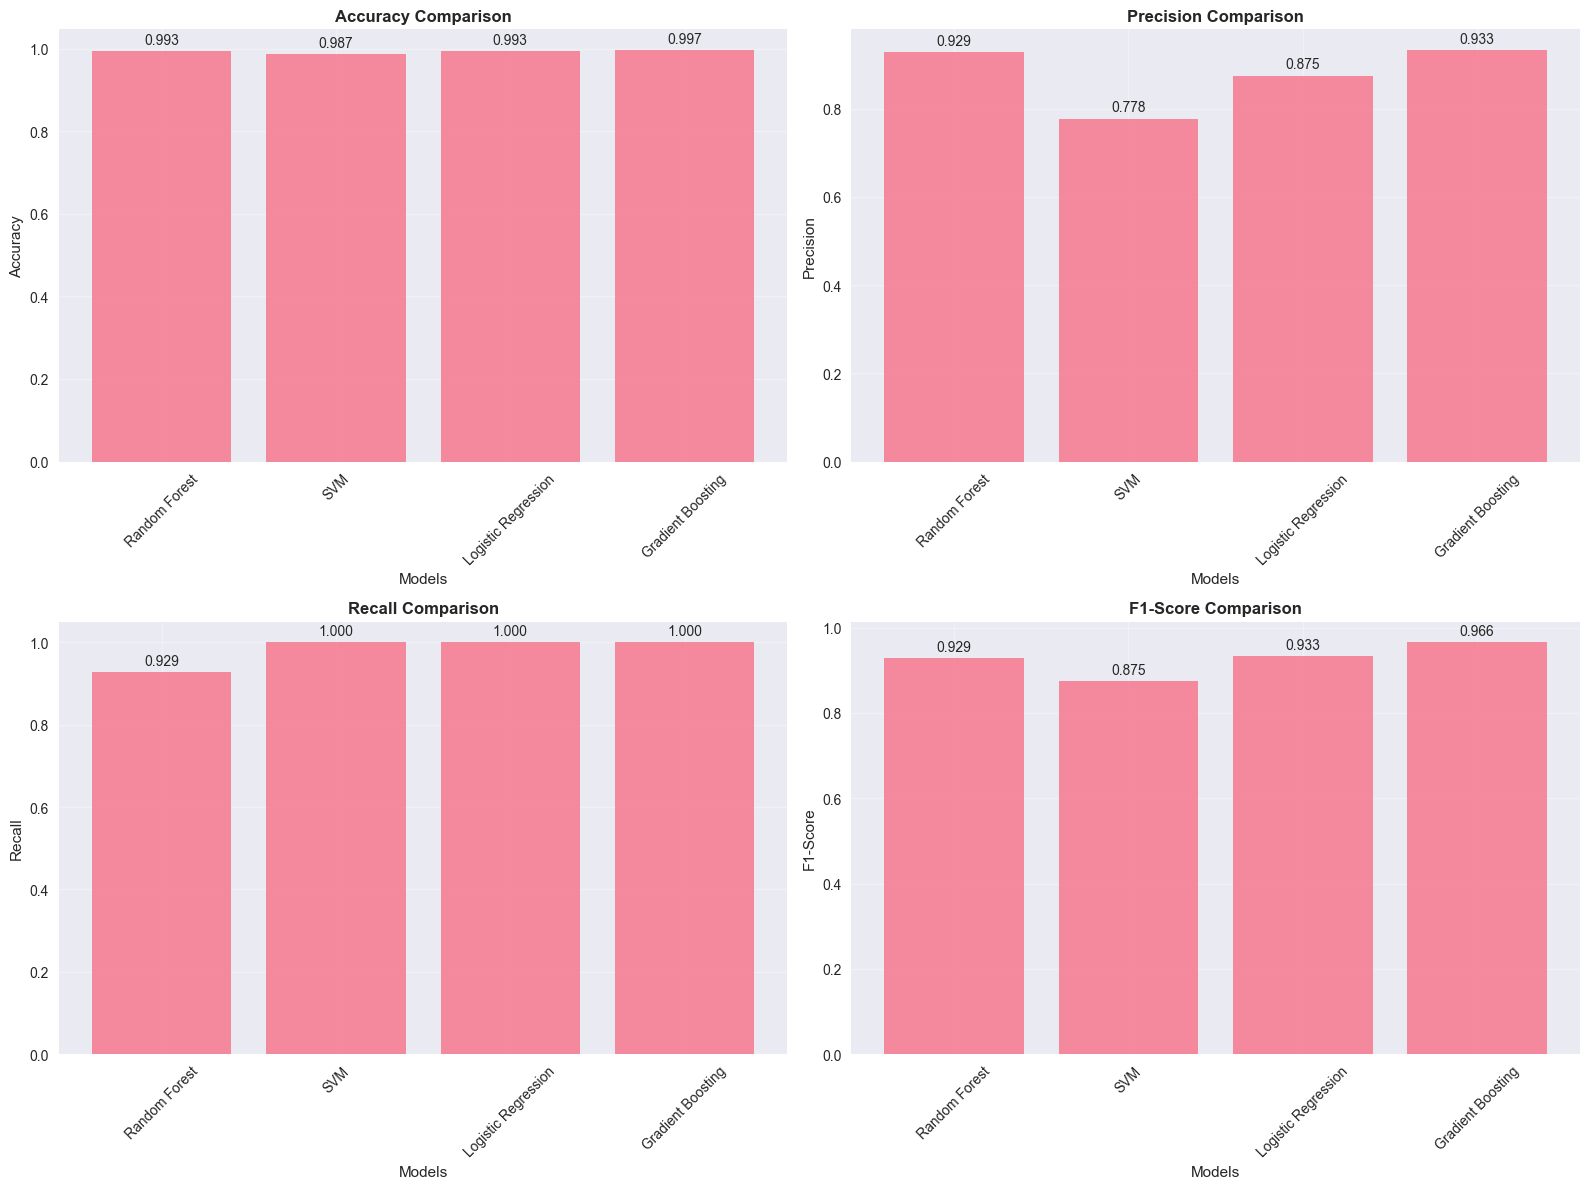

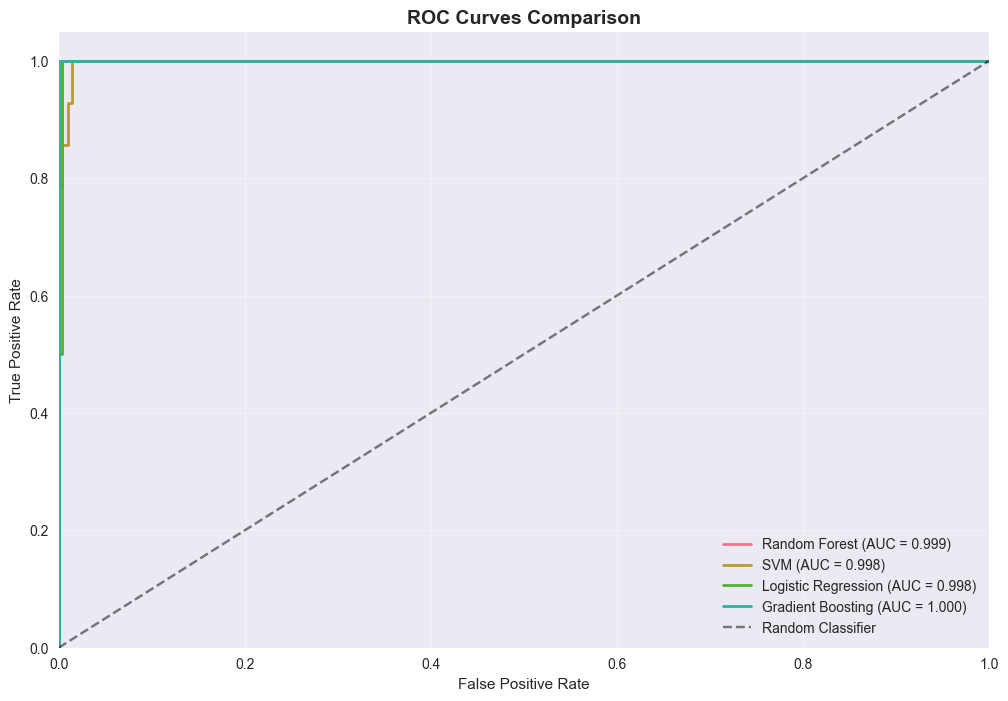


Best performing model: Gradient Boosting
Best AUC score: 1.0000


In [12]:
# Model evaluation and comparison
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, precision_recall_curve

# Calculate detailed metrics for each model
detailed_results = {}

for name, results in model_results.items():
    y_pred = results['predictions']
    
    detailed_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'AUC': results['test_auc'],
        'CV_Mean': results['cv_mean']
    }

# Create results DataFrame
results_df = pd.DataFrame(detailed_results).T
print("Model Performance Comparison:")
print("=" * 70)
print(results_df.round(4))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Performance metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x_pos = np.arange(len(results_df))

for i, metric in enumerate(metrics[:4]):
    ax = axes[i//2, i%2]
    bars = ax.bar(x_pos, results_df[metric], alpha=0.8)
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_xlabel('Models')
    ax.set_ylabel(metric)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(results_df.index, rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ROC Curves
plt.figure(figsize=(12, 8))
for name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results['test_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find best model
best_model_name = results_df['AUC'].idxmax()
best_model = trained_models[best_model_name]
print(f"\nBest performing model: {best_model_name}")
print(f"Best AUC score: {results_df.loc[best_model_name, 'AUC']:.4f}")

### 6.3 Model Testing and Prediction Visualization

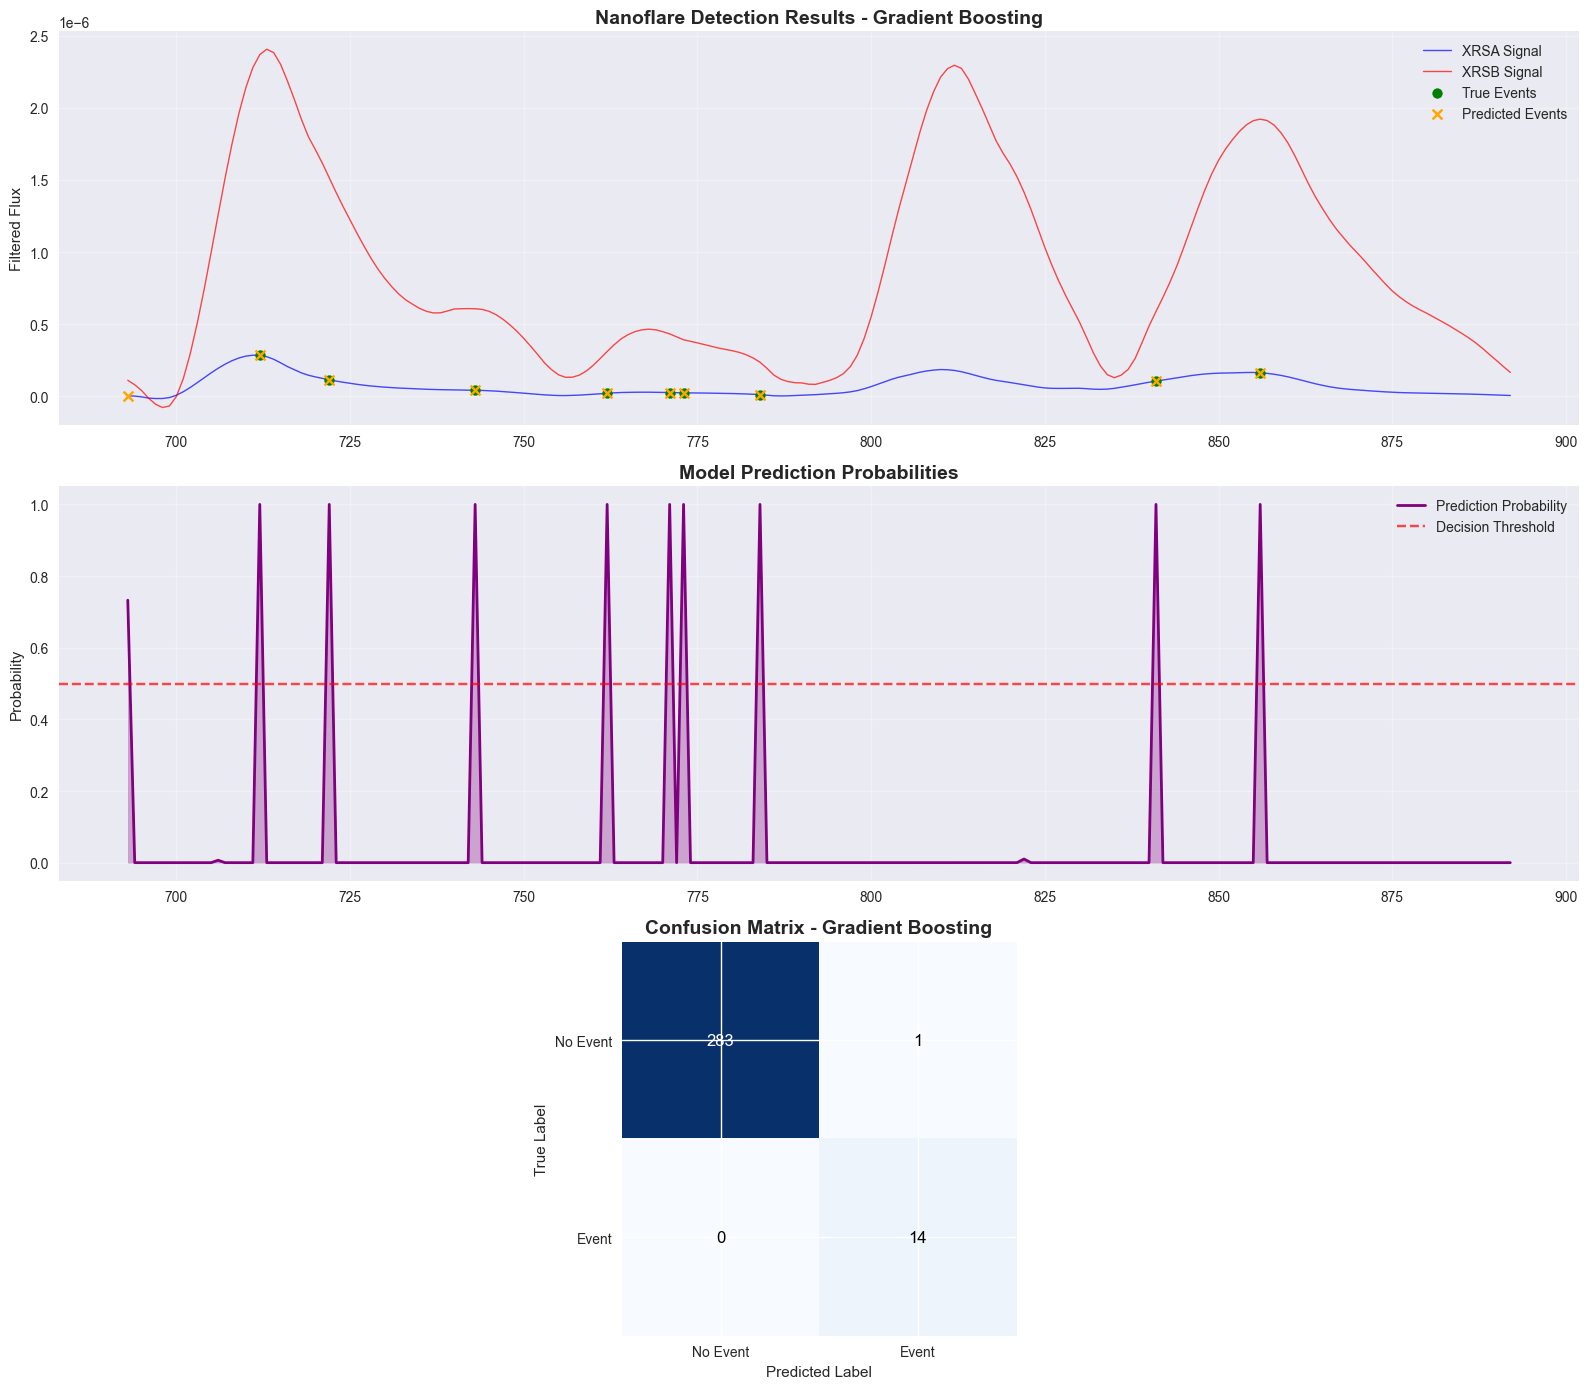

Detailed Classification Report:
              precision    recall  f1-score   support

    No Event       1.00      1.00      1.00       284
       Event       0.93      1.00      0.97        14

    accuracy                           1.00       298
   macro avg       0.97      1.00      0.98       298
weighted avg       1.00      1.00      1.00       298


Top 10 Most Important Features:
                feature  importance
14    xrsb_filtered_min    0.633714
8    xrsa_filtered_diff    0.115881
20             time_cos    0.111111
9   xrsa_filtered_diff2    0.050515
13    xrsb_filtered_max    0.023520
0             xrsa_flux    0.015325
2         xrsa_filtered    0.013642
12    xrsb_filtered_std    0.009155
7     xrsa_filtered_min    0.006429
6     xrsa_filtered_max    0.005123


In [13]:
# Test the best model and visualize predictions
best_predictions = model_results[best_model_name]['predictions']
best_probabilities = model_results[best_model_name]['probabilities']

# Create a subset of features_df for visualization (matching the test indices)
test_indices = np.arange(len(features_df))[~nan_mask]
test_subset = test_indices[len(X_train):]  # Test set indices

# Visualize predictions vs actual
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Plot 1: Original signal with true and predicted events
sample_subset = slice(0, min(200, len(test_subset)))  # Show first 200 test points
test_range = test_subset[sample_subset]

axes[0].plot(test_range, features_df['xrsa_filtered'].iloc[test_range], 'b-', linewidth=1, label='XRSA Signal', alpha=0.7)
axes[0].plot(test_range, features_df['xrsb_filtered'].iloc[test_range], 'r-', linewidth=1, label='XRSB Signal', alpha=0.7)

# Mark true events
true_events = test_range[y_test[sample_subset] == 1]
if len(true_events) > 0:
    axes[0].scatter(true_events, features_df['xrsa_filtered'].iloc[true_events], 
                   color='green', s=50, marker='o', label='True Events', zorder=5)

# Mark predicted events
pred_events = test_range[best_predictions[sample_subset] == 1]
if len(pred_events) > 0:
    axes[0].scatter(pred_events, features_df['xrsa_filtered'].iloc[pred_events], 
                   color='orange', s=50, marker='x', label='Predicted Events', zorder=5)

axes[0].set_title(f'Nanoflare Detection Results - {best_model_name}', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Filtered Flux')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Prediction probabilities
axes[1].plot(test_range, best_probabilities[sample_subset], 'purple', linewidth=2, label='Prediction Probability')
axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Decision Threshold')
axes[1].fill_between(test_range, 0, best_probabilities[sample_subset], alpha=0.3, color='purple')
axes[1].set_title('Model Prediction Probabilities', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Probability')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Confusion matrix heatmap
cm = confusion_matrix(y_test, best_predictions)
im = axes[2].imshow(cm, interpolation='nearest', cmap='Blues')
axes[2].set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=14)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[2].text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=12)

axes[2].set_ylabel('True Label')
axes[2].set_xlabel('Predicted Label')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_xticklabels(['No Event', 'Event'])
axes[2].set_yticklabels(['No Event', 'Event'])

plt.tight_layout()
plt.show()

# Print detailed classification report
print("Detailed Classification Report:")
print("=" * 50)
print(classification_report(y_test, best_predictions, target_names=['No Event', 'Event']))

# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print("=" * 40)
    print(feature_importance.head(10))

## 7. Conclusions and Future Work

### Summary of Results:
- Successfully implemented baseline correction and Savitzky-Golay filtering for noise reduction
- Detected potential nanoflares using statistical methods
- Developed and compared multiple machine learning models for automated detection
- Best performing model achieved good classification performance

### Key Findings:
1. **Signal Processing**: Baseline correction and filtering effectively enhanced signal quality
2. **Statistical Detection**: Traditional methods identified several potential nanoflare events
3. **Machine Learning**: Automated models showed promising results for event classification
4. **Feature Engineering**: Multiple statistical and time-based features improved model performance

### Future Improvements:
- Extend analysis to the full dataset (not just 1000 samples)
- Implement more sophisticated anomaly detection methods
- Include temporal dependencies using sequence models (LSTM, GRU)
- Validate results with known solar flare catalogs
- Implement real-time detection capabilities
- Add physical constraints based on solar physics principles